In [1]:
# for analysis
import pandas as pd
import datetime as dt
import scipy as sp
import scipy.stats as stats

# for plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 16}
matplotlib.rc('font', **font)

# for retreiving data
import sqlite3
from src import clean_data as d
conn = sqlite3.connect('data/billboard-200.db')

In [2]:
# use src/clean_data.py to compile dataframes from raw data
albums_raw, albums, artists, songs = d.get()
song_parameters = d.song_parameters
normal_parameters = d.normal_parameters

In [3]:
def weighted_score(param, chart):
    power_rank_col = chart['power']
    param_col = chart[param]
    return (power_rank_col * param_col).sum() / power_rank_col.sum()

def vibe(chart, params = song_parameters):
        return {p:weighted_score(p, chart) for p in params}

# Vibe of Popular Music Over Time

Compile all the popularity of each element across every week from 1963-2019

In [4]:
weekly_charts = albums_raw.merge(albums, 
                                   on=['album','artist'], 
                                   how='left'
                                  ).groupby('date')

week_dates = [date for date in weekly_charts.groups.keys()]
week_scores = [vibe(chart) for _, chart in weekly_charts]

# Timeseries containing the scores for every week
parameter_ts = pd.DataFrame(week_scores, index=week_dates)

# Timeseries containing the change from last week
# for each parameter (ie. a bootleg derivative)
parameter_ts_derivative = parameter_ts.diff()

# Vibe Plots

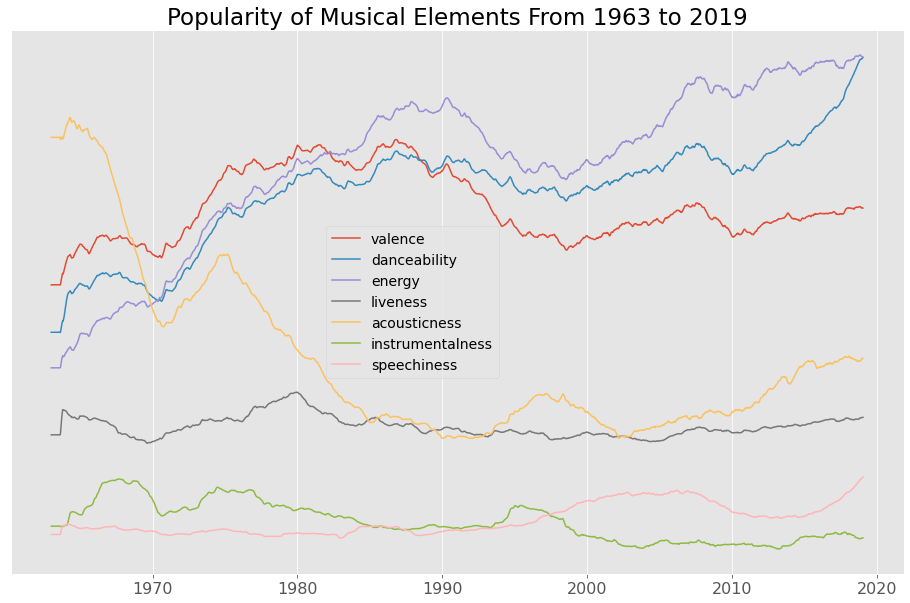

In [5]:
# Resample timeseries by every 200 weeks to smooth out noise
delta = dt.timedelta(weeks=200)
rolling_avg = parameter_ts.rolling(delta).mean()

fig, ax = plt.subplots(figsize=(16,10))
for p in normal_parameters:
    ax.plot(rolling_avg.index, rolling_avg[p])

ax.set_title('Popularity of Musical Elements From 1963 to 2019')
ax.get_yaxis().set_visible(False)
ax.legend(normal_parameters, fontsize=14, loc='center', bbox_to_anchor=(0.45, 0.5))

# fig.savefig('images/vibe_full_timeseries.png')

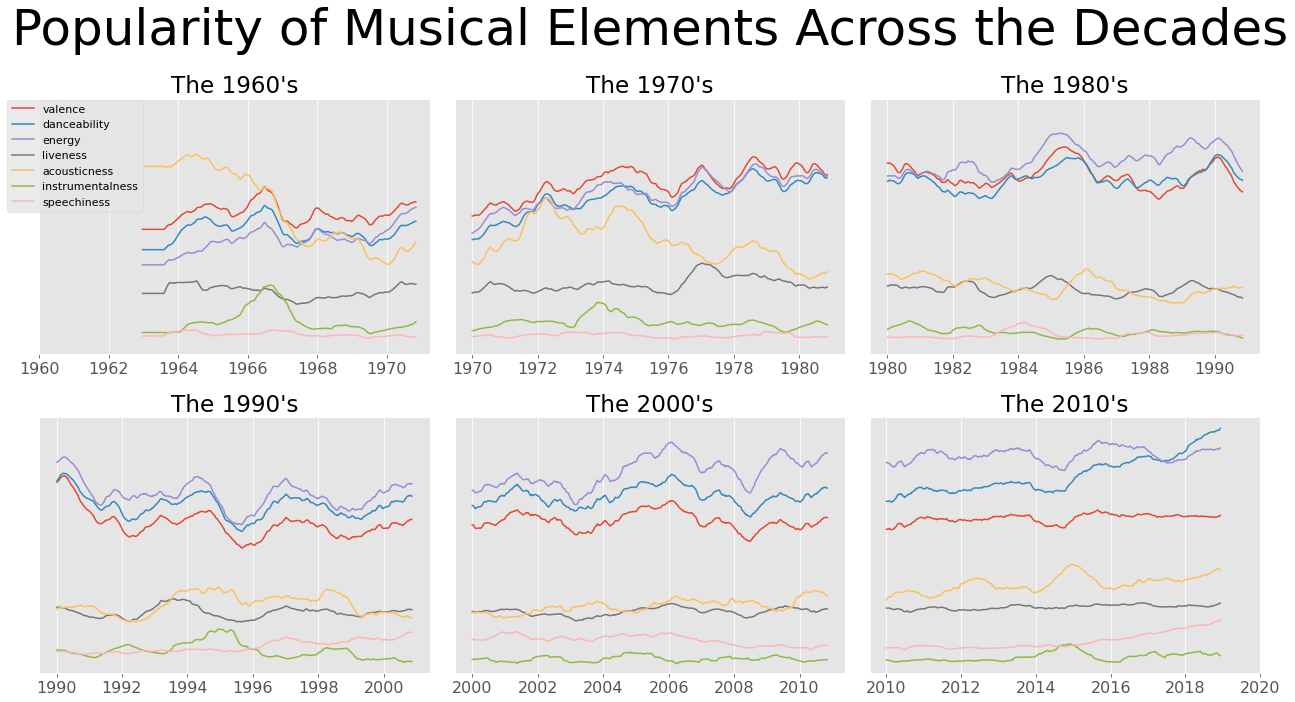

In [6]:
delta = dt.timedelta(weeks=50)
rolling_avg = parameter_ts.rolling(delta).mean()

sixties       = rolling_avg.loc['1960':'1970']
seventies     = rolling_avg.loc['1970':'1980']
eighties      = rolling_avg.loc['1980':'1990']
nineties      = rolling_avg.loc['1990':'2000']
two_thousands = rolling_avg.loc['2000':'2010']
twenty_tens   = rolling_avg.loc['2010':'2020']

decade_ts = [sixties,
            seventies,
            eighties,
            nineties,
            two_thousands,
            twenty_tens]

decade_names = ["1960's",
                "1970's",
                "1980's",
                "1990's",
                "2000's",
                "2010's"]

timestamps = [dt.date(1960, 1, 1),
              dt.date(1970, 1, 1),
              dt.date(1980, 1, 1),
              dt.date(1990, 1, 1),
              dt.date(2000, 1, 1),
              dt.date(2010, 1, 1)]

fig, ax = plt.subplots(2, 3, figsize=(18,10))
for a, name, ts, timestamp in zip(ax.flatten(), decade_names, decade_ts, timestamps):
    for p in normal_parameters:
        a.plot(ts.index, ts[p])

    a.set_title(f'The {name}')
    a.set_ylabel('Popularity')
    a.set_ylim(0, .65)
    a.get_yaxis().set_visible(False)
    
    years = [timestamp + i*dt.timedelta(days=370) for i in range(0, 11, 2)]
    a.set_xticks(years)
    a.set_xticklabels([year.year for year in years])
    
fig.legend(normal_parameters, fontsize=11, loc='upper left', bbox_to_anchor=(0., 0.858))
fig.suptitle('Popularity of Musical Elements Across the Decades', fontsize=50)
fig.tight_layout()

# fig.savefig('images/vibe_by_decade.png')

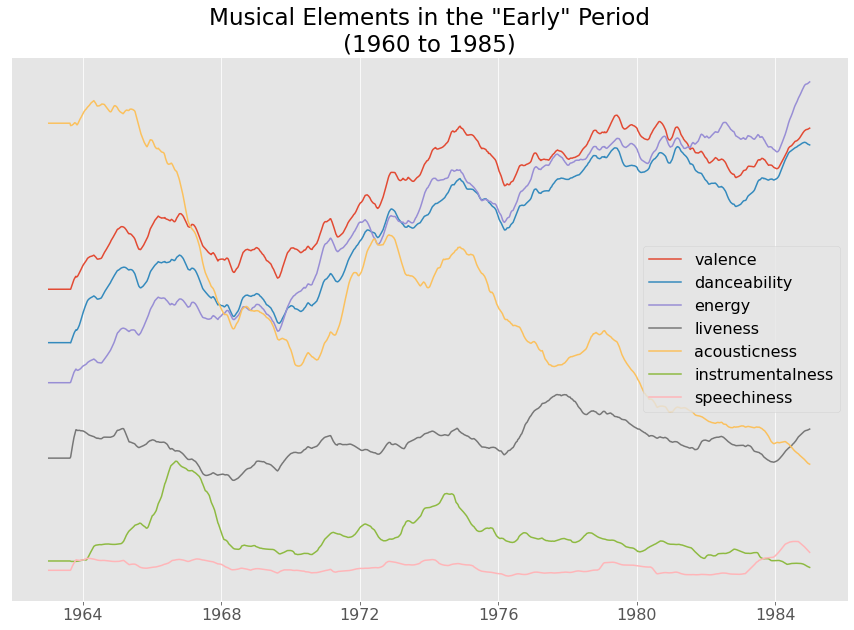

In [7]:
delta = dt.timedelta(weeks=80)
start = dt.date(1960, 1, 1)
end = dt.date(1985, 1, 1)
rolling_avg = parameter_ts.rolling(delta).mean().loc[start:end]

fig, ax = plt.subplots(figsize=(15,10))
for p in normal_parameters:
    ax.plot(rolling_avg.index, rolling_avg[p])

ax.set_title(f'Musical Elements in the "Early" Period\n({start.year} to {end.year})')
ax.get_yaxis().set_visible(False)
ax.legend(normal_parameters);

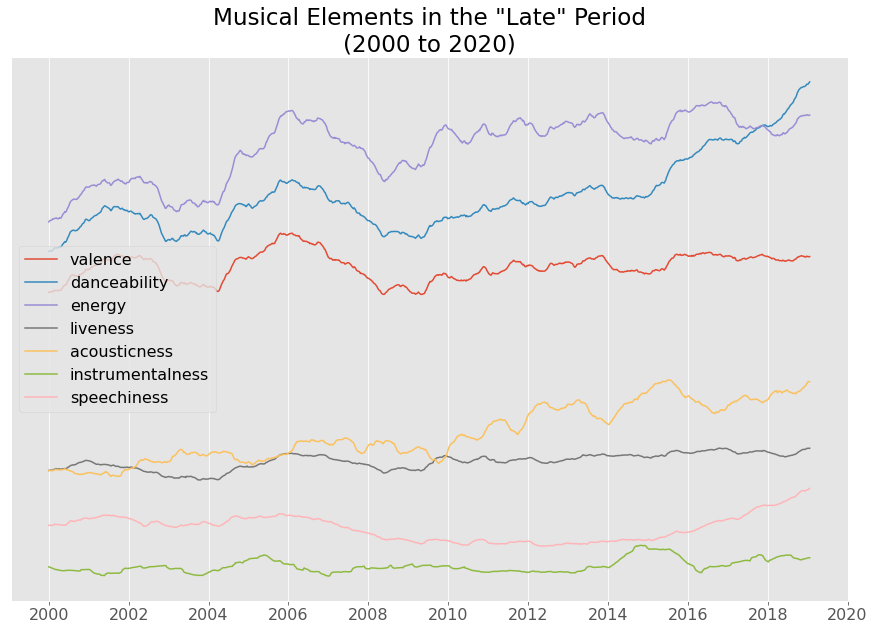

In [8]:
delta = dt.timedelta(weeks=80)
start = dt.date(2000, 1, 1)
end = dt.date(2020, 1, 1)
rolling_avg = parameter_ts.rolling(delta).mean().loc[start:end]

fig, ax = plt.subplots(figsize=(15,10))
for p in normal_parameters:
    ax.plot(rolling_avg.index, rolling_avg[p])

ax.set_title(f'Musical Elements in the "Late" Period\n({start.year} to {end.year})')
ax.get_yaxis().set_visible(False)
ax.legend(normal_parameters);

# Vibe Hypotheses

In [9]:
early_period = parameter_ts.loc['1960':'1985']
late_period  = parameter_ts.loc['2000':'2020']

## Increase in "Speechiness" after the Rise of Rap and Hip-Hop

Hypothesis: The the average "speechiness" of music after 2000 is greater than that of music from 1960-1985

$$ H_0: \ \mu_{post\ 2000} \leq \mu_{pre\ 1985} $$

$$ H_A: \ \mu_{post\ 2000} > \mu_{pre\ 1985} $$

$$ \alpha = .05 $$

In [10]:
early_speechiness = early_period['speechiness']
late_speechiness  = late_period['speechiness']

T, p_val = stats.ttest_ind(late_speechiness, early_speechiness, equal_var=False)

# stats.ttest_ind performs a two sided test
# to convert to one side, divide p_val by two
# and only reject null Hypothesis with T > 0
if p_val/2 < .05 and T > 0:
    print(f'Successfully Rejected Null Hypothesis with p = {p_val/2 : .3e}')
else:
    print(f'Failed to Reject Null Hypothesis with p={p_val/2 : .3e}')

Successfully Rejected Null Hypothesis with p =  4.127e-219


## Decreasing Popularity of Instrumental Music

Hypothesis: The the average "instrumentalness" of music after 2000 is less than that of music from 1960-1985

$$ H_0: \ \mu_{post\ 2000} \geq \mu_{pre\ 1985} $$

$$ H_A: \ \mu_{post\ 2000} < \mu_{pre\ 1985} $$

$$ \alpha = .05 $$

In [11]:
early_instrumentalness = early_period['instrumentalness']
late_instrumentalness = late_period['instrumentalness']

T, p_val = stats.ttest_ind(late_instrumentalness, early_instrumentalness, equal_var=False)

# stats.ttest_ind performs a two sided test
# to convert to one side, divide p_val by two
# and only reject null Hypothesis with T < 0
if p_val/2 < .05 and T < 0:
    print(f'Successfully Rejected Null Hypothesis with p = {p_val/2 : .3e}')
else:
    print(f'Failed to Reject Null Hypothesis with p={p_val/2 : .3e}')

Successfully Rejected Null Hypothesis with p =  2.180e-158
